In [1]:
import numpy as np
 

Pytorch Version: 2.9.0+cu128
GPU is available


/home/orincon/miniconda3/envs/pinn-driven-mechanics-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


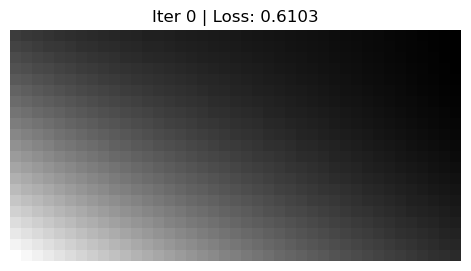

[Epoch 0] Loss: 0.610295, Vol: 0.544


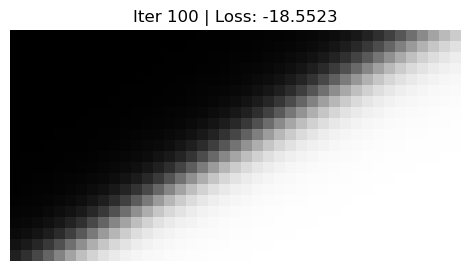

[Epoch 100] Loss: -18.552349, Vol: 0.508


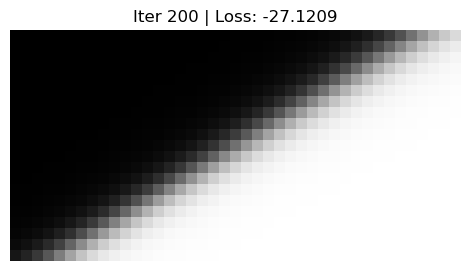

[Epoch 200] Loss: -27.120930, Vol: 0.508


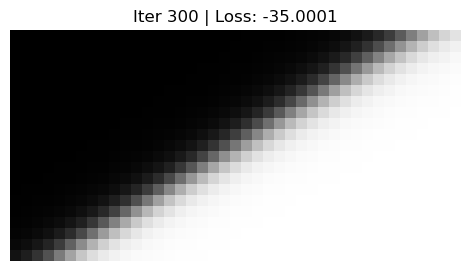

[Epoch 300] Loss: -35.000088, Vol: 0.504


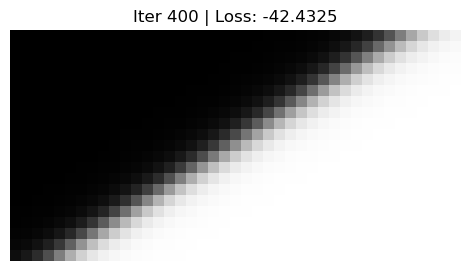

[Epoch 400] Loss: -42.432526, Vol: 0.491


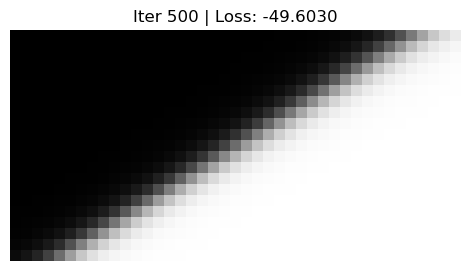

[Epoch 500] Loss: -49.602978, Vol: 0.509


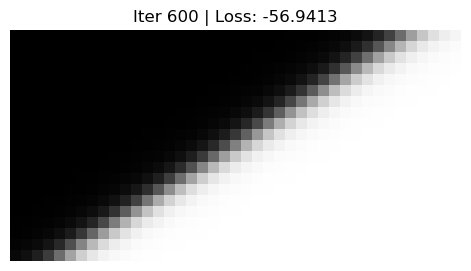

[Epoch 600] Loss: -56.941303, Vol: 0.499


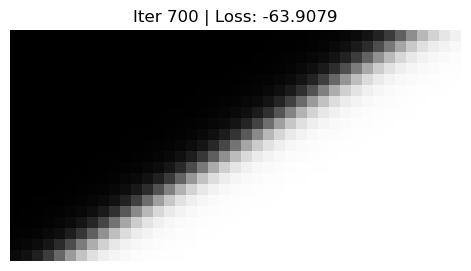

[Epoch 700] Loss: -63.907898, Vol: 0.505


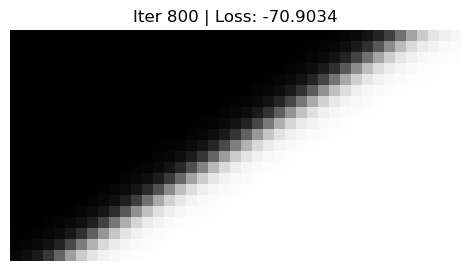

[Epoch 800] Loss: -70.903374, Vol: 0.499


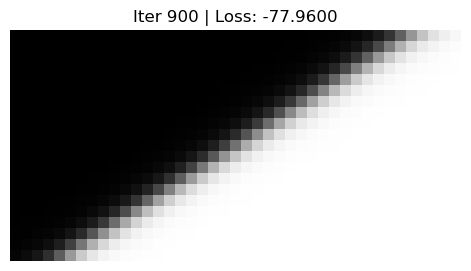

[Epoch 900] Loss: -77.959984, Vol: 0.504


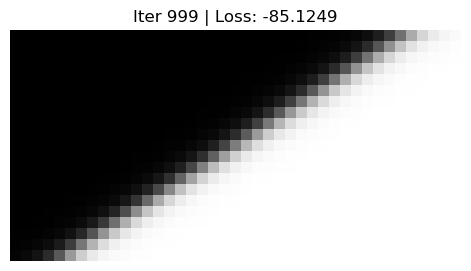

[Epoch 999] Loss: -85.124893, Vol: 0.500


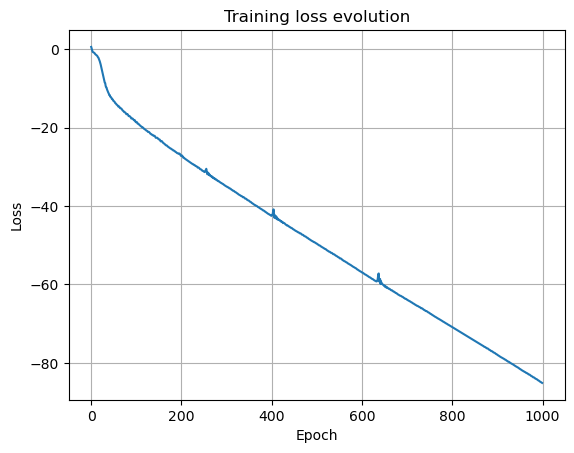

In [2]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import time, os, random

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#%% Device setup
print(f"Pytorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

#%% Reproducibility
manualSeed = 1234
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
random.seed(manualSeed)

#%% Helper function: pooling for visualization
def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):
    A = np.pad(A, padding, mode='constant')
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    A_w = as_strided(A, shape_w, strides_w)
    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))

#%% Network architecture
class Net(nn.Module):
    """General fully-connected neural network for displacement or density.
    
    Args:
        n_input (int): number of input features
        n_output (int): number of output features
        n_layer (int): number of hidden layers
        n_nodes (int): number of neurons per hidden layer
    Returns:
        torch.Tensor: predicted field (displacement or density)
    """
    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.Input = nn.Linear(n_input, n_nodes)
        self.Hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.Output = nn.Linear(n_nodes, n_output)

        # Xavier initialization
        for layer in [self.Input, *self.Hidden, self.Output]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        return self.Output(y)

#%% Problem setup
nelx, nely = 40, 20
x, y = np.meshgrid(np.linspace(0, 2, nelx+1), np.linspace(0, 1, nely+1))
y = np.flipud(y)
data = np.hstack([x.reshape(-1,1, order='F'), y.reshape(-1,1, order='F')])
data = torch.tensor(data, dtype=torch.float32, requires_grad=True, device=device)

X, Y = np.meshgrid(np.linspace(0,2,nelx), np.linspace(0,1,nely))
Y = np.flipud(Y)
idx_f = np.where((data[:,0].cpu()==2.0) & (data[:,1].cpu()==0.5))

# BCs
ndof = 2*(nelx+1)*(nely+1)
dofs = np.arange(ndof)
fixed = np.arange(2*(nely+1))
free = np.setdiff1d(dofs, fixed)
f = np.zeros((ndof,1))
f[2*(nelx+1)*(nely+1)-(nely+1),0] = -1

# Material and parameters
mu = 0.3
Emin, Emax = 1e-9, 10.0
penal = 3.0
volfrac = 0.5
P = 1.0

# Element stiffness matrix
def lk():
    E, nu = 1, 0.3
    k = np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,
                  -1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
    KE = E/(1-nu**2)*np.array([
        [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
        [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
        [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
        [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
        [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
        [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
        [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
        [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
    return KE
KE = lk()

#%% Initialize networks
Net_u = Net(2, 1, 8, 80).to(device)
Net_v = Net(2, 1, 8, 80).to(device)
Net_rho = Net(2, 1, 5, 40).to(device)  # Density network

# Activation scaling for rho
sigmoid = nn.Sigmoid()

# Optimizer
params = list(Net_u.parameters()) + list(Net_v.parameters()) + list(Net_rho.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50)

#%% Training loop
epochs = 1000
loss_hist = []

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Displacement fields
    u = Net_u(data) * data[:,0:1]
    v = Net_v(data) * data[:,1:2]
    
    # Density field
    rho = sigmoid(Net_rho(data))
    
    # Material interpolation
    E = Emin + (rho**penal)*(Emax - Emin)
    G = E / (2*(1+mu))
    lam = mu*E / ((1+mu)*(1-2*mu))
    
    # Derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    dux, duy = du[:,0:1], du[:,1:2]
    dvx, dvy = dv[:,0:1], dv[:,1:2]
    
    # Strains
    ex, ey = dux, dvy
    gxy = dvx + duy
    e = ex + ey
    
    # Stresses
    sx = 2*G*ex + lam*e
    sy = 2*G*ey + lam*e
    txy = G*gxy
    
    # Energy terms
    Eint = torch.mean(0.5*(sx*ex + sy*ey + txy*gxy))
    Eext = Net_v(data[idx_f]) * -P
    
    # Volume regularization
    vol_penalty = torch.abs(torch.mean(rho) - volfrac)
    
    # Total loss
    loss = Eint - Eext + 10.0*vol_penalty
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    loss_hist.append(loss.item())

    # Plot every 100 epochs
    if epoch % 100 == 0 or epoch == epochs-1:
        rho_plot = rho.detach().cpu().numpy().reshape(nely+1, nelx+1, order='F')
        plt.figure(figsize=(6,3))
        plt.imshow(-rho_plot, cmap='gray')
        plt.title(f"Iter {epoch} | Loss: {loss.item():.4f}")
        plt.axis('off')
        plt.show()
        print(f"[Epoch {epoch}] Loss: {loss.item():.6f}, Vol: {torch.mean(rho).item():.3f}")

#%% Plot loss history
plt.figure()
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss evolution")
plt.grid(True)
plt.show()
